# Defining an External Source

OpenMC provides several options for defining an external source definition and additions in the most recent releases have provided additional capability. There are currently three primary classes for defining a source:

- `openmc.IndependentSource`
- `openmc.FileSource`
- `openmc.MeshSource`
- `openmc.CompiledSource`

We'll briefly go through each of these classes with the exception of `CompiledSource`, which is a bit more involved as it requires compiling a source class written in C++. `CompiledSource` is typically used when the source definition does not fit cleanly in any of the other formalisms; common examples here would be the neutron source in a tokamak or stellarator, or a beam-target source with a complex angle-energy distribution.

## `IndepedentSource`

The `IndependentSource`, which we have already seen briefly in our previous examples, allows you to define distributions in space, angle, and energy that are sampled _independently_ (hence the name). To demonstrate this, we first need a model to work with. We'll define a very simple problem composed of two cylinders, one made of U235 and one made of Al.

In [1]:
import openmc
import random
import math

u235 = openmc.Material()
u235.add_nuclide('U235', 1.0)
u235.set_density('g/cm3', 5.0)

al = openmc.Material()
al.add_element('Al', 1.0)
al.set_density('g/cm3', 2.7)

cyl1 = openmc.ZCylinder(r=5.0)
cyl2 = openmc.ZCylinder(r=10.0, boundary_type='vacuum')
bottom = openmc.ZPlane(-10.0, boundary_type='vacuum')
top = openmc.ZPlane(10.0, boundary_type='vacuum')

inner = openmc.Cell(fill=u235, region=-cyl1 & +bottom & -top)
outer = openmc.Cell(fill=al, region=+cyl1 & -cyl2 & +bottom & -top)
model = openmc.Model()
model.geometry = openmc.Geometry([inner, outer])

Now let's define the source. We'll start with the simplest source possible, which is a point source. All spatial, angular, and energy distributions can be found in the `openmc.stats` submodule. For a point source, we use `openmc.stats.Point`.

In [2]:
space = openmc.stats.Point((1., 1., 0.))
model.settings.source = openmc.IndependentSource(space=space)

As with the `Cell` and `Universe` classes, the `Model` class also has a `plot` method, but with a `Model` we can also plot sampled source sites alongside the geometry.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

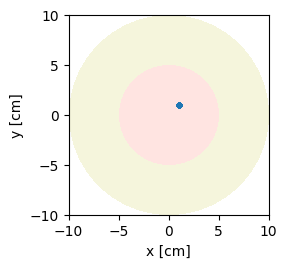

In [3]:
plot_kwargs = {
    'n_samples': 500,
    'plane_tolerance': 10.0,
    'source_kwargs': {'marker': '.'},
    'colors': {inner: 'mistyrose', outer: 'beige'},
}

model.plot(**plot_kwargs)

The source shows up as a single point, as expected. Also note that when we don't specify anything for the angle distribution, it defaults to isotropic and the energy distribution defaults to a Watt fission spectrum.

Let's change the source to a box source covering the inner cylinder.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

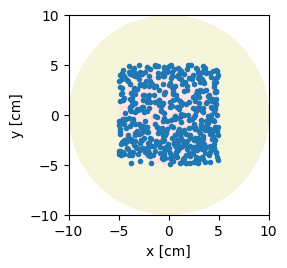

In [4]:
bbox = inner.bounding_box
space = openmc.stats.Box(bbox.lower_left, bbox.upper_right)
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

If we want the points to appear only in the cylinder, we can use the `openmc.stats.CylindricalIndependent` class.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

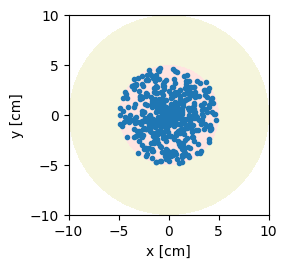

In [5]:
space = openmc.stats.CylindricalIndependent(
    r=openmc.stats.Uniform(0., 5.),
    phi=openmc.stats.Uniform(0., 2*math.pi),
    z=openmc.stats.delta_function(0.0)
)
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

Notice that the points are not uniformly distributed over the cylinder, preferrentially clustering at smaller radii. To make it uniform, the radial distribution needs to be power-law distributed:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

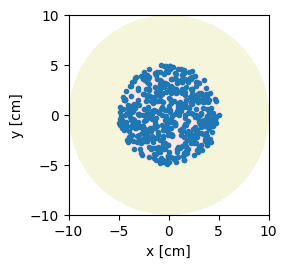

In [6]:
space = openmc.stats.CylindricalIndependent(
    r=openmc.stats.PowerLaw(0., 5., 1),
    phi=openmc.stats.Uniform(0., 2*math.pi),
    z=openmc.stats.delta_function(0.0)
)
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

There is an easier way we could have achieved this, though less efficient, which is to keep our original box distribution but then constrain it to the region inside the `inner` cell:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

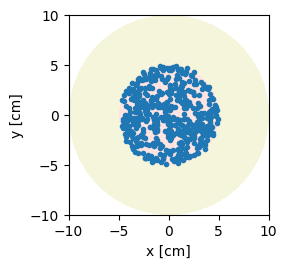

In [7]:
space = openmc.stats.Box(bbox.lower_left, bbox.upper_right)
model.settings.source = openmc.IndependentSource(space=space, constraints={'domains': [inner]})
model.plot(**plot_kwargs)

To change the angle or energy distribution, we use the `angle=` and `energy=` arguments when creating an instance of `IndependentSource`. For the angle distribution, our options are:

- `openmc.stats.Isotropic`
- `openmc.stats.Monodirectional`
- `openmc.stats.PolarAzimuthal`

For the energy distribution, any univariate distribution is accepted, which includes:

- `openmc.stats.Discrete`
- `openmc.stats.ContinuousTabular`
- `openmc.stats.Uniform`
- `openmc.stats.Mixture`
- `openmc.stats.Normal`
- ...

See [here](https://docs.openmc.org/en/latest/pythonapi/stats.html) for the full list of univariate distributions. Also note that for the common case where you want the source at a single energy, you can use the `delta_function` function.

## `FileSource`

The `FileSource` class allows you to specify a source from an external HDF5 file that contains a finite number of discrete source sites. Source files can be created in a number of manners:

- $k$-eigenvalue calculations will store the fission source in the statepoint file (or a separate source file).
- A surface source can be collected during a simulation using the `Settings.surf_source_write` setting.
- Discrete source sites can be created in the Python API and written to file using the `openmc.ParticleList` class.
- An [MCPL](https://mctools.github.io/mcpl/) file written from another code can be used.

Let's demonstrate how we can create a source file using the `ParticleList` class. This class takes a list of `SourceParticle` objects that we create individually. Let's start by creating monoenergetic points along a ring.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

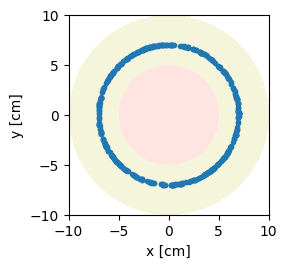

In [8]:
radius = 7.0

particles = openmc.ParticleList()
for i in range(1000):
    phi = random.uniform(0., 2.*math.pi)
    x = math.cos(phi) * radius
    y = math.sin(phi) * radius
    p = openmc.SourceParticle(r=(x, y, 0.0))
    particles.append(p)

particles.export_to_hdf5('source.h5')
model.settings.source = openmc.FileSource('source.h5')
model.plot(**plot_kwargs)

Let's add a little "wobble" to the sampled source sites by making the radius a sine function.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

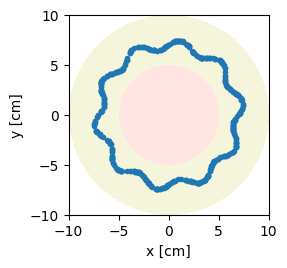

In [9]:
particles = openmc.ParticleList()
for i in range(1000):
    phi = random.uniform(0., 2.*math.pi)
    x = math.cos(phi) * (radius + 0.5*math.sin(10*phi))
    y = math.sin(phi) * (radius + 0.5*math.sin(10*phi))
    p = openmc.SourceParticle(r=(x, y, 0.0))
    particles.append(p)

particles.export_to_hdf5('source.h5')
model.settings.source = openmc.FileSource('source.h5')
model.plot(**plot_kwargs)

## `MeshSource` and `MeshSpatial`

Finally, there are two classes that allow us to define a source distributed on a mesh:

- `MeshSpatial`: for this class, we can specify source intensities on each mesh element and then use it within `IndependentSource`
- `MeshSource`: this class behaves like `MeshSpatial` except it allows unique energy and angle distributions for each mesh element.

We'll demonstrate the simpler `MeshSpatial` class.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

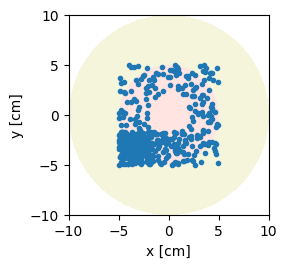

In [10]:
mesh = openmc.RegularMesh()
mesh.lower_left = (-5., -5., -1.)
mesh.upper_right = (5., 5., 1.)
mesh.dimension = (3, 3, 1)

space = openmc.stats.MeshSpatial(mesh, strengths=[9.0, 3.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0])
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)